# Linear elasticity in a multipatch domain

In [21]:
%pylab inline
import scipy
import itertools

from pyiga import bspline, assemble, vform, geometry, vis, solvers

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# assemble matrix
from scipy.sparse import coo_matrix, block_diag, bmat

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\MHeig\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['f', 'bmat']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [22]:
p = 1   # spline degree 
n_el = (3, 3)   # number of elements in y/x direction, isotropic material
#n_el = (50, 10)   # number of elements in y/x direction, isotropic material
#n_el = (50, 20)   # number of elements in y/x direction
# displacement space: degree p,   continuity p-1
kvs = tuple(bspline.make_knots(p, 0.0, 1.0, n, mult=1) for n in n_el) # or : mult=2
m_u = tuple(kv.numdofs for kv in kvs)


In [23]:
# define geometry map

geos = [
    geometry.unit_square().scale((5,1)),
    geometry.unit_square().scale((5,1)).translate((5,0))
]

patches = [(kvs, g) for g in geos]

#print(kvs)


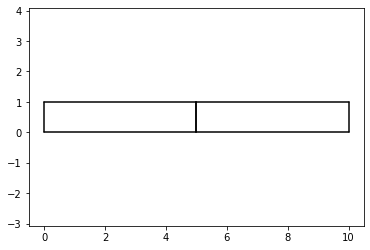

In [24]:
for g in geos:
    vis.plot_geo(g,grid=2)
axis('equal');

In [25]:
# rubber, Lamé-coeff.
Mu = 0.003 # [GPa]
Lam = 0.00028416 #  [GPa] (under ass. ny=0.48, almost incompressible)

In [26]:
def A11_vf(dim):
    from pyiga.vform import VForm, grad, inner, div, dx, Dx
    vf = VForm(dim)
    u, v = vf.basisfuns()
    
    grad_uv= inner(grad(u), grad(v))
    div_11 = Dx(u,0) * Dx(v,0)
    
    vf.add(Mu * ( grad_uv +  div_11) * dx  + Lam *div_11 * dx )
    return vf

def A12_vf(dim):
    from pyiga.vform import VForm, grad, inner, div, dx, Dx
    vf = VForm(dim)
    u, v = vf.basisfuns()

    grad_uv= inner(grad(u), grad(v))
    div_12 = Dx(u,1) * Dx(v,0)
    div_21 = Dx(u,0) * Dx(v,1)
    
    vf.add(Mu * div_21 * dx  + Lam *div_12 * dx )
    return vf

           
def A21_vf(dim):
    from pyiga.vform import VForm, grad, inner, div, dx, Dx
    vf = VForm(dim)
    u, v = vf.basisfuns()

    grad_uv= inner(grad(u), grad(v))
    div_12 = Dx(u,1) * Dx(v,0)
    div_21 = Dx(u,0) * Dx(v,1)
    
    vf.add( Mu * div_12 * dx  + Lam *div_21* dx )
    return vf
           
def A22_vf(dim):
    from pyiga.vform import VForm, grad, inner, div, dx, Dx
    vf = VForm(dim)
    u, v = vf.basisfuns()

    grad_uv= inner(grad(u), grad(v))
    div_22 = Dx(u,1) * Dx(v,1)
    
    vf.add(Mu * ( grad_uv +  div_22) * dx  + Lam *div_22 * dx)
    return vf


#A = bmat([[A11, A12], [A21, A22]]) works

In [27]:
# source term f 
f = lambda x,y: (0.0)  # source term

In [28]:
#Neumann BC
def g_N(x, y): return (-3e-7) # Neumann BC function

def g0(x,y):
    if (x>4).all():
        return -3e-7 # set force at distal end only
    else:
        return 0
    
def g(x,y):
    if isinstance(x,numpy.float64):
        return (g0(x,y))
    return ([g0(xi,0) for xi in np.nditer(x)])


# set inhom. Neumann cond. on distal end, hom. NBC elsewhere
neu_data = [
    #(0, 'top', g),
    (1, 'top', g_N) 
]

MP = assemble.Multipatch(patches, {'N':neu_data}, automatch=True)

#MP = assemble.Multipatch(patches, automatch=True) # without Neumann! 

In [29]:
#MP.shared_per_patch
#MP.shared_dofs
#print(MP.global_to_patch(1))

In [30]:
#A, rhs, N = MP.assemble_system(linelast_vf(2), vform.L2functional_vf(2, physical=True), f=f)

A11, rhs1, nbc11 = MP.assemble_system(A11_vf(2), vform.L2functional_vf(2, physical=True), f=f)
A12, rhs12, nbc2 = MP.assemble_system(A12_vf(2), vform.L2functional_vf(2, physical=True), f=f) 
A21, rhs21, nbc21 = MP.assemble_system(A21_vf(2), vform.L2functional_vf(2, physical=True), f=f) 
A22, rhs2, nbc22 = MP.assemble_system(A22_vf(2), vform.L2functional_vf(2, physical=True), f=f)

A = bmat([[A11, A12], [A21, A22]])

print(shape(A11))
print(shape(A))


(28, 28)
(56, 56)


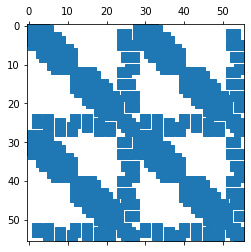

In [31]:
spy(A)

In [32]:
#print(rhs1)
#print(rhs2)
rhs= np.hstack((rhs1, rhs2))
#rhs = np. zeros(sh) # rhs =0
print(shape(rhs))
#print(rhs)

#combine Neumann-BC to appropriate shape
nbc= np.hstack((np.zeros(shape(nbc11)), nbc22)) ##???
print(shape(nbc))
print(nbc)


(56,)
(56,)
[ 0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00
  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00
  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00
  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00
  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00
  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00
  0.0e+00 -5.0e-07 -5.0e-07 -2.5e-07  0.0e+00  0.0e+00  0.0e+00 -2.5e-07]


In [33]:
# Dirichlet BC
# Dirichlet boundary function g
def g_zero(x, y): return (0.0) # scalar!

bcs = MP.compute_dirichlet_bcs([
    (0, 'left', g_zero)
])
#print(shape(bcs))
#print(bcs)

#num= np.prod(tuple(kv.numdofs for kv in kvs)) # inner dofs
#print(kvs)
#print(2*num)
print(MP.numdofs) # golbal dofs

bcs2= bcs[0]+MP.numdofs 


bcs12= np.append(bcs[0],bcs2)
bcs22 = np.append(bcs[1],bcs[1])
#print(bcs12)
bc= [bcs12, bcs22]
#print(shape(bc))
print(bc)

# vectorize bcs
bcs = MP.compute_dirichlet_bcs_vec([
    (0, 'left', g_zero)
])
print(shape(bcs))
print(bcs)


28
[array([ 0,  3,  6,  9, 28, 31, 34, 37]), array([0., 0., 0., 0., 0., 0., 0., 0.])]
(2, 8)
(array([ 0,  3,  6,  9, 28, 31, 34, 37]), array([0., 0., 0., 0., 0., 0., 0., 0.]))


In [41]:
# set up and solve linear system
LS = assemble.RestrictedLinearSystem(A, rhs +nbc, bcs) #

u = LS.complete(solvers.make_solver(LS.A, spd=True).dot(LS.b))

#print(shape(u))
#print(u)


In [35]:
#N= np.prod(tuple(kv.numdofs for kv in kvs))
#print(N) 
print(MP.numdofs) # global dofs (=all dofs interface dofs,i.e. 2x16-4 = 28)
print(2*MP.numdofs) 

u1 = u[:MP.numdofs] 
u2 = u[MP.numdofs:2*MP.numdofs]
#print(shape(u1))
#print(u1)
#print(shape(u2))
#print(u2)

#print(MP.global_to_patch(1))
#print(MP.patch_to_global(1))

28
56


In [36]:
# restrict solution to each individual patch
u1_funcs = [geometry.BSplineFunc(kvs, MP.global_to_patch(p) @ u1)
           for p in range(len(patches))]
u2_funcs = [geometry.BSplineFunc(kvs, MP.global_to_patch(p) @ u2)
           for p in range(len(patches))]


In [37]:
def plot_grid(x,y, ax=None, **kwargs):
    ax = ax or plt.gca()
    segs1 = np.stack((x,y), axis=2)
    segs2 = segs1.transpose(1,0,2)
    ax.add_collection(LineCollection(segs1, **kwargs))
    ax.add_collection(LineCollection(segs2, **kwargs))
    ax.autoscale()
    

In [38]:
# evaluate displacement and "pressure" over a grid in the parameter domain
xgrid = linspace(0, 1, 5)
xygrid = (xgrid, xgrid)


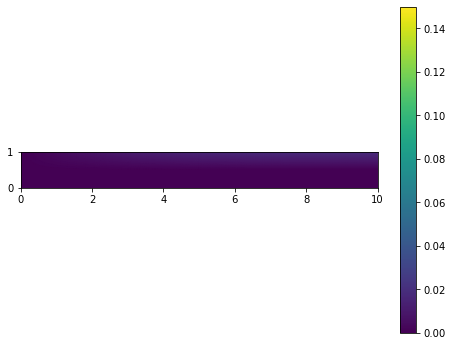

In [39]:
figsize(8,6)

for (u1_func, (kvs, geo)) in zip(u1_funcs, patches):
    #print(u_func)
    vis.plot_field((u1_func), geo, vmin=0, vmax=1.5e-1)
axis('scaled')
colorbar();

(0.0, 10.018121082207319, -0.2655171147181262, 1.0)

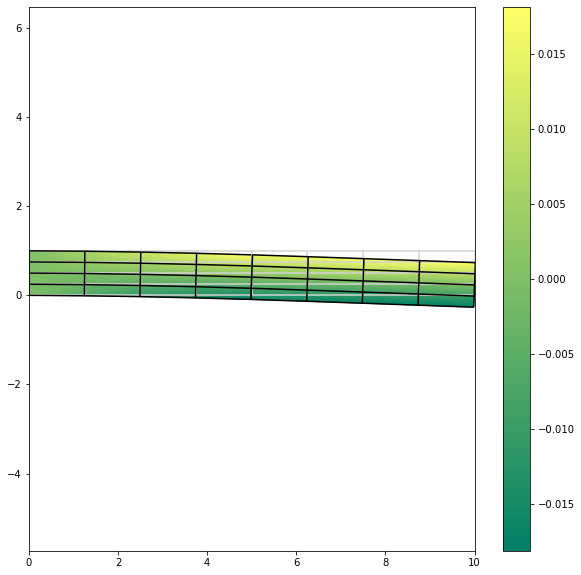

In [40]:
figsize(10,10)
fig, ax = plt.subplots()

#i=0
for (u1_func, u2_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, patches): #u_funcs 
    #print(i)
    dis1 = u1_func.grid_eval(xygrid)
    
    dis2 = u2_func.grid_eval(xygrid) 
    
    G = geo.grid_eval(xygrid)
    plot_grid(G[...,0], G[...,1], ax=ax, color="lightgrey")
    plot_grid(G[...,0]+dis1, G[...,1]+dis2,ax=ax, color="black")
    pcolormesh(G[...,0]+dis1, G[...,1]+dis2, dis1, cmap='summer', shading='gouraud');
    #i+=1
    #print('dis1= ', dis1)
    #print('dis2= ', dis2)

colorbar();
axis('equal')
